# Modelling and Visualization


In this notebook, we fit models to the joined traffic and collisions dataset, in an attempt to predict whether there are collisions near a given intersection.  We do so by running a grid search over a variety of model types and hyperparameters, and choosing the combination which yields the highest test accuracy.  With this best model we then showcase how such a tool might be used in practice, by providing probabilistic estimates of collision locations, based on a set of traffic measurements at a given time.  Finally, we visualize traffic fluctuations over time for a specific intersection, and show how the coefficients might be interpreted for a logistic regression classifier built for this intersection.

We begin by importing the standard libraries, and the joined dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
joined = pd.read_csv('Data/joined_by_hour.csv')

joined.head()

,Id_Intersection,Date,hour,Longitude,Latitude,Year,Month,Day,weekday,NB,SB,EB,WB,collision_nearby
0,1,2018-02-14,0,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
1,1,2018-02-14,1,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
2,1,2018-02-14,2,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
3,1,2018-02-14,3,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
4,1,2018-02-14,4,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0


In [4]:
joined.shape

(72319, 14)

It looks as though the table loaded as expected.  Let's binarize the `collision_nearby` column, and drop columns which cannot be used by models.

In [5]:
# binarize collision_nearby
joined['is_collision'] = np.where(joined['collision_nearby'] > 0, 1, 0)

# drop some non-useful columns
joined.drop(columns=['Id_Intersection', 'Date', 'collision_nearby'], inplace=True)

# check results
joined.head()

,hour,Longitude,Latitude,Year,Month,Day,weekday,NB,SB,EB,WB,is_collision
0,0,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
1,1,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
2,2,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
3,3,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0
4,4,-73.575661,45.48265,2018,2,14,2,0,0,0,0,0


### Model Fitting

When modelling, it is good practice to check the performance of a 'baseline' model.  Here, we will check the distribution of values in the target variable, and calculate our accuracy if we were simply to predict the mode.

In [6]:
spread = joined['is_collision'].value_counts()
print(spread)

spread.values[0] / (spread.values[0] + spread.values[1])

0    42281
1    30038
Name: is_collision, dtype: int64


0.5846458053900082

This baseline here would yield an accuracy of 58.5%.  With this in mind, we can now continue with fitting real models.  We start by performing a train-test split, and running a grid search over different variations of models and hyperparameters.

We perform the train-test split with the `shuffle` option set to `False`.  This is because in our case, shuffling the dataset might actually allow for data leakage into the test set.  Recall that each traffic entry is mapped to all collisions which occurred 'nearby', where the definition of being 'nearby' is dependent on a time threshold that we set.  This means that each collision can get mapped to multiple traffic entries (e.g. intersection #10 at 1 pm, and intersection #10 at 2 pm), and so if we shuffle the DataFrame when we split, this would likely result in single collisions being present in both the train and test sets.  By not shuffling, we preserve the order of the dataset and keep each individual collision on one side of the split.

In [7]:
# import the different sklearn packages we will need
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')

In [8]:
# ensure that the dataset is sorted by date-time
joined.sort_values(['Year', 'Month', 'Day', 'hour'], inplace=True)
joined = joined.reset_index().drop('index', axis=1)
joined.head()

,hour,Longitude,Latitude,Year,Month,Day,weekday,NB,SB,EB,WB,is_collision
0,0,-73.615006,45.627322,2012,1,19,3,0,0,0,0,0
1,1,-73.615006,45.627322,2012,1,19,3,0,0,0,0,0
2,2,-73.615006,45.627322,2012,1,19,3,0,0,0,0,0
3,3,-73.615006,45.627322,2012,1,19,3,0,0,0,0,0
4,4,-73.615006,45.627322,2012,1,19,3,0,0,0,0,0


In [12]:
# split into features and target
X = joined.iloc[:, :-1]
y = joined['is_collision']

# train test ssplit with the shuffle set to False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, shuffle=False)

In [9]:
# step 1: set up the pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearSVC())]

pipe = Pipeline(estimators)

# step 2: set up the gridsearch
param_grid = [
             {'model': [LinearSVC()],
             'normalise': [StandardScaler(), MinMaxScaler()],
             'model__penalty': ['l1', 'l2'],
             'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
            {'model': [DecisionTreeClassifier()],
             'model__max_depth': np.arange(1, 10)},
    
            {'model': [LogisticRegression(penalty='l2')], 
             'normalise': [StandardScaler(), MinMaxScaler()],
             'model__solver': ['lbfgs', 'newton-cg', 'sag', 'liblinear', 'saga'],
             'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
    
            {'model': [LogisticRegression(penalty='l1')],
             'normalise': [StandardScaler(), MinMaxScaler()], 
             'model__solver': ['liblinear', 'saga'],
             'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}    

]

# step 3: instantiate and fit the GridSearch object
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2)
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 167 candidates, totalling 835 fits
[CV] model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler() 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(), total=   0.1s
[CV] model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=StandardScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=0.0001, model__penalty=l1, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=0.0001, model

[CV]  model=LinearSVC(), model__C=0.01, model__penalty=l1, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler(), total=   0.2s
[CV] model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler(), total=   0.2s
[CV] model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler(), total=   0.3s
[CV] model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler(), total=   0.2s
[CV] model=LinearSVC(), model__C=0.01, model__penalty=l2, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=0.01, model__penalty=l2, normalis

[CV]  model=LinearSVC(), model__C=1, model__penalty=l2, normalise=StandardScaler(), total=   5.1s
[CV] model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler(), total=   0.8s
[CV] model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler(), total=   1.1s
[CV] model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler(), total=   0.7s
[CV] model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler(), total=   0.7s
[CV] model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1, model__penalty=l2, normalise=MinMaxScaler(), total=   0.8s
[CV] model=Linear

[CV]  model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler() 
[CV]  model=LinearSVC(), model__C=1000, model__penalty=l1, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LinearSVC(), model__C=1000, model__penalty=l2, normalise=StandardScaler() 
[CV]  model=LinearSVC(), model__C=1000, model__penalty=l2, normalise=StandardScaler

[CV]  model=DecisionTreeClassifier(), model__max_depth=3, total=   0.1s
[CV] model=DecisionTreeClassifier(), model__max_depth=4 ..............
[CV]  model=DecisionTreeClassifier(), model__max_depth=4, total=   0.1s
[CV] model=DecisionTreeClassifier(), model__max_depth=4 ..............
[CV]  model=DecisionTreeClassifier(), model__max_depth=4, total=   0.1s
[CV] model=DecisionTreeClassifier(), model__max_depth=4 ..............
[CV]  model=DecisionTreeClassifier(), model__max_depth=4, total=   0.1s
[CV] model=DecisionTreeClassifier(), model__max_depth=4 ..............
[CV]  model=DecisionTreeClassifier(), model__max_depth=4, total=   0.1s
[CV] model=DecisionTreeClassifier(), model__max_depth=4 ..............
[CV]  model=DecisionTreeClassifier(), model__max_depth=4, total=   0.1s
[CV] model=DecisionTreeClassifier(), model__max_depth=5 ..............
[CV]  model=DecisionTreeClassifier(), model__max_depth=5, total=   0.1s
[CV] model=DecisionTreeClassifier(), model__max_depth=5 ..............

[CV]  model=LogisticRegression(), model__C=0.0001, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler(), total=   0.4s
[CV] model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=0.0001, model__solver=sag, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.0001

[CV] model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=0.001, model__solver=saga, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.01, model__solver=lbfgs, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=0.01, model__solver=lbfgs, normalise=StandardScaler(), total=   0.0s
[CV] model=LogisticRegression(), model__C=0.01, model__solver=lbfgs, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=0.01, model__solver=lbfgs, normalise

[CV]  model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=0.1, model__solver=sag, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=0.1, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=0.1, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=0.1, model__solver=liblinear, normalise

[CV]  model=LogisticRegression(), model__C=1, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=1, model__solver=newton-cg, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=1, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=1, model__solver=newton-cg, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=1, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=1, model__solver=newton-cg, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=1, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=1, model__solver=sag, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=1, model__solver=sag, normalise=StandardScaler(), total=   0.3s
[CV] model=LogisticRegression(), model__C=1, model__solver=sag, norma

[CV]  model=LogisticRegression(), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=10, model__solver=lbfgs, normalise=MinMaxScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=10, model__solver=newton-cg, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=10, model__solver=newton-cg, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=10, model__solver=newton-cg, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=10, model__solver=newton-cg, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=10, model__solver=newt

[CV]  model=LogisticRegression(), model__C=10, model__solver=saga, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=10, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=10, model__solver=saga, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=10, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=10, model__solver=saga, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=StandardScaler(), total=   0.0s
[CV] model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=StandardScaler(), total=   0.0s
[CV] model=LogisticRegression(), model__C=100, model__solver=lbfgs, normalise=Sta

[CV]  model=LogisticRegression(), model__C=100, model__solver=liblinear, normalise=MinMaxScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=100, model__solver=liblinear, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=100, model__solver=liblinear, normalise=MinMaxScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=100, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=100, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=100, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=100, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=100, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=100, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=100, model__solver=

[CV]  model=LogisticRegression(), model__C=1000, model__solver=sag, normalise=MinMaxScaler(), total=   0.4s
[CV] model=LogisticRegression(), model__C=1000, model__solver=sag, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=1000, model__solver=sag, normalise=MinMaxScaler(), total=   0.3s
[CV] model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=1000, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(), model__

[CV]  model=LogisticRegression(), model__C=10000, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=10000, model__solver=newton-cg, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=10000, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=10000, model__solver=newton-cg, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(), model__C=10000, model__solver=newton-cg, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(), model__C=10000, model__solver=sag, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=10000, model__solver=sag, normalise=StandardScaler(), total=   0.3s
[CV] model=LogisticRegression(), model__C=10000, model__solver=sag, normalise=StandardScaler() 
[CV]  model=LogisticRegression(), model__C=10000, model__solver=sag, normalise=StandardScaler(), total=   0.3s
[CV] model=LogisticRegression(), model__C

[CV]  model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=liblinear, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=liblinear, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=liblinear, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=liblinear, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=liblinear, normalise=MinMaxScaler(), total=   0.0s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=saga, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.0001, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'),

[CV]  model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=MinMaxScaler(), total=   0.5s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.01, model__solver=liblinear, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1

[CV]  model=LogisticRegression(penalty='l1'), model__C=0.1, model__solver=saga, normalise=MinMaxScaler(), total=   0.2s
[CV] model=LogisticRegression(penalty='l1'), model__C=0.1, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=0.1, model__solver=saga, normalise=MinMaxScaler(), total=   0.3s
[CV] model=LogisticRegression(penalty='l1'), model__C=1, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=1, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(penalty='l1'), model__C=1, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=1, model__solver=liblinear, normalise=StandardScaler(), total=   0.1s
[CV] model=LogisticRegression(penalty='l1'), model__C=1, model__solver=liblinear, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=1, model__solver=lib

[CV]  model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler(), total=   0.3s
[CV] model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler(), total=   0.3s
[CV] model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler(), total=   0.3s
[CV] model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=10, model__solver=saga, normalise=MinMaxScaler(), t

[CV]  model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler(), total=   0.2s
[CV] model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=saga, normalise=StandardScaler() 
[CV]  model=LogisticRegression(penalty='l1'), model__C=1000, model__solver=s

[Parallel(n_jobs=1)]: Done 835 out of 835 | elapsed:  6.1min finished


We can save the gridsearch object, so that the results can simply be loaded back into memory later.

In [10]:
joblib.dump(fittedgrid, 'grid_search.pkl')

['grid_search.pkl']

We can also pull out the best combination of hyperparameters:

In [10]:
fittedgrid.best_estimator_

NameError: name 'fittedgrid' is not defined

It looks like our best model is a decision tree with a max depth of 5.  We can check the train and test scores:

In [13]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train);

dt.score(X_train, y_train)

0.7062483795696137

In [14]:
dt.score(X_test, y_test)

0.7237278761061947

With fairly close train and test scores, it looks as though the model is fitting the data quite well, and both are higher than the baseline model.  One concern would be that the model is simply learning the 'clusters' of collisions, since there are clusters of ones in the times surrounding each accident.  This is hopefully mitigated by choosing to not shuffle the data during the train-test split, but may remain an issue and require further investigation.  Perhaps we could take traffic counts at time intervals spaced further apart, so that there are not multiple 'ones' clustered around each collision time.  This would be a good next step for future iterations of the project, but will not be explored here.

### Predictive Capabilities in Practice

We can also use our decision tree model to showcase how a tool like this might be used in practice.  We can pull out all of the traffic entries we have for a specific day and time, and show the predictions that would be made by our model.  Note that for illustration purposes, we will use entries from the *original* `joined` table, despite violating basic principles because the model was *trained* on these values.  The reason for this, is that once the train-test split is performed, there is not enough data in the test set to find a single day and hour with multiple entries.  In a real world application, we could record new traffic counts at various locations simultaneously, and generate predictions from those.

In [15]:
test_rows = joined.loc[(joined['Year'] == 2018) & (joined['Month'] == 2) & (joined['Day'] == 14) \
                      & (joined['hour'] == 8), :]
test_rows

,hour,Longitude,Latitude,Year,Month,Day,weekday,NB,SB,EB,WB,is_collision
37217,8,-73.575661,45.482650,2018,2,14,2,466,146,294,347,1
37218,8,-73.587639,45.473984,2018,2,14,2,0,2,354,324,0
37219,8,-73.574439,45.483398,2018,2,14,2,68,79,387,308,1
37220,8,-73.562987,45.495417,2018,2,14,2,969,338,754,164,1
37221,8,-73.571767,45.485016,2018,2,14,2,56,151,368,297,1
37222,8,-73.563755,45.494298,2018,2,14,2,1,103,723,206,1
37223,8,-73.573591,45.481004,2018,2,14,2,514,241,142,0,0


In this case, the majority of intersections for which we have entries seem to have a collision which occurred nearby.  We can check how well our model would predict this outcome, by looking at the probabilistic and hard predictions:

In [16]:
X_test_rows = test_rows.iloc[:, :-1]
y_test_rows = test_rows['is_collision']

probs = dt.predict_proba(X_test_rows)
ones = [round(x[1], 2) for x in probs]

test_rows['prob'] = ones
test_rows['pred'] = np.where(test_rows['prob'] > 0.5, 1, 0)
test_rows

,hour,Longitude,Latitude,Year,Month,Day,weekday,NB,SB,EB,WB,is_collision,prob,pred
37217,8,-73.575661,45.482650,2018,2,14,2,466,146,294,347,1,0.68,1
37218,8,-73.587639,45.473984,2018,2,14,2,0,2,354,324,0,0.44,0
37219,8,-73.574439,45.483398,2018,2,14,2,68,79,387,308,1,0.68,1
37220,8,-73.562987,45.495417,2018,2,14,2,969,338,754,164,1,0.68,1
37221,8,-73.571767,45.485016,2018,2,14,2,56,151,368,297,1,0.68,1
37222,8,-73.563755,45.494298,2018,2,14,2,1,103,723,206,1,0.68,1
37223,8,-73.573591,45.481004,2018,2,14,2,514,241,142,0,0,0.68,1


In observing the results, it seems as though we would predict there being a collision near all of these intersections, which is actually not too wrong.  We do see a lower probability for the second intersection which is encouraging, since in reality, for this case there *was* no collision nearby.  It could be that many of these intersections are near the same collision, hence the identical probabilities for most entries.  Despite this being the case, one could imagine a situation where the intersections are not all so close to the collision, and so emergency services could monitor traffic counts at intersections across the city, and direct attention towards those which yield high probabilities for accidents.

### Investigation Into Coefficients

One final insight we can take from these kinds of models is the proportion that each feature contributes to the likelihood of a collision being nearby.  This is not such an easy task with decision tree models (especially ones of max depth 10), but is manageable for logistic regression classifiers.  Here, we investigate how the `NB` and `SB` coefficients vary for an intersection located north of the downtown core, specifically how they vary over the course of a day.  This could be interesting, given that such an intersection would be expected to show greater *southbound* traffic in the morning, and greater *northbound* traffic in the evening (due to commuters driving to and from work).

We start by re-reading in the dataset, and filtering for intersection #1660.

In [19]:
# re-read in the data
joined = pd.read_csv('Data/joined_by_hour.csv')

# filter for intersection 1660
joined = joined.loc[joined['Id_Intersection'] == 1660, :].reset_index().drop('index', axis=1)

#binarize is_collision again
joined['is_collision'] = np.where(joined['collision_nearby'] > 0, 1, 0)

# drop non-useful columns
joined.drop(columns=['Id_Intersection', 'Longitude', 'Latitude', 'Date', 'collision_nearby'], inplace=True)

# check result
joined.head()

,hour,Year,Month,Day,weekday,NB,SB,EB,WB,is_collision
0,16,2015,5,29,4,1490,1141,1288,244,0
1,17,2015,5,29,4,1482,1135,1267,241,0
2,18,2015,5,29,4,1065,1030,867,198,0
3,19,2015,5,29,4,809,908,558,201,0
4,20,2015,5,29,4,771,781,552,120,0


In [20]:
joined.shape

(2281, 10)

We can also check that our hunch is valid, by visualizing the northbound and southbound traffic over time:

In [21]:
# group by hour and take the mean traffic count
by_hour = joined.groupby('hour').mean()[['NB', 'SB', 'EB', 'WB']].reset_index()
by_hour.head()

,hour,NB,SB,EB,WB
0,0,170.842105,142.421053,72.242105,22.821053
1,1,95.084211,82.252632,35.410526,11.957895
2,2,64.568421,54.410526,21.673684,9.294737
3,3,58.294737,52.168421,16.242105,7.884211
4,4,69.600000,71.400000,18.410526,14.557895


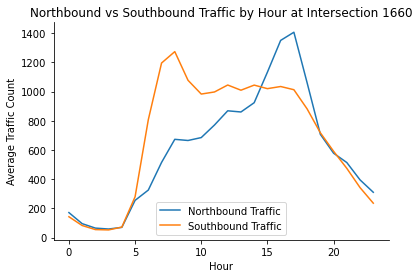

In [22]:
plt.figure()
plt.plot(by_hour['hour'], by_hour['NB'], label='Northbound Traffic')
plt.plot(by_hour['hour'], by_hour['SB'], label='Southbound Traffic')
plt.title('Northbound vs Southbound Traffic by Hour at Intersection 1660')
plt.xlabel('Hour')
plt.ylabel('Average Traffic Count')
plt.legend()
sns.despine()
plt.show()

From the visual, it appears as though our hunch is correct.  We see heavy southbound traffic in the morning (people commuting to work downtown), and heavy northbound traffic in the evening (people coming home from work).  We will therefore continue with the modelling. 

We should note that in filtering the data down to a single intersection, we dramatically reduce the size of the dataset.  As a result, we should not expect a logistic regression classifier to display particularly high accuracy, but it can still be interesting to observe the variation in the coefficients.  

We will fit two models here, one for the morning traffic entries and one for the evening ones.

In [23]:
# separate joined into morning and evening
morning = joined.loc[(joined['hour'] < 12), :]
evening = joined.loc[(joined['hour'] >= 12), :]

# separate into features and target
X_morning = morning.iloc[:, :-2]
y_morning = morning['is_collision']
X_evening = evening.iloc[:, :-2]
y_evening = evening['is_collision']

# train test split on morning
X_morning_train, X_morning_test, y_morning_train, y_morning_test = train_test_split(X_morning, 
                                                                                    y_morning,
                                                                                    test_size=0.2,
                                                                                    random_state=99,
                                                                                    shuffle=False)

# train test split on evening
X_evening_train, X_evening_test, y_evening_train, y_evening_test = train_test_split(X_evening,
                                                                                   y_evening,
                                                                                   test_size=0.2,
                                                                                   random_state=99,
                                                                                   shuffle=False)

# fit scaler on morning
scaler_morning = StandardScaler()
scaler_morning.fit(X_morning_train, y_morning_train)

# fit scaler on evening
scaler_evening = StandardScaler()
scaler_evening.fit(X_evening_train, y_evening_train)

# transform morning
X_morning_train_scaled = scaler_morning.transform(X_morning_train)
X_morning_test_scaled = scaler_morning.transform(X_morning_test)

# transform evening
X_evening_train_scaled = scaler_evening.transform(X_evening_train)
X_evening_test_scaled = scaler_evening.transform(X_evening_test)

In [24]:
# fit morning model
logreg_morning = LogisticRegression()
logreg_morning.fit(X_morning_train_scaled, y_morning_train);

# fit evening model
logreg_evening = LogisticRegression()
logreg_evening.fit(X_evening_train_scaled, y_evening_train);

We can then check the train and test accuracies of each of these models:

In [25]:
print(f'Morning Train: {logreg_morning.score(X_morning_train_scaled, y_morning_train)}')

print(f'Morning Test: {logreg_morning.score(X_morning_test_scaled, y_morning_test)}')

print(f'Evening Train: {logreg_evening.score(X_evening_train_scaled, y_evening_train)}')

print(f'Evening Test: {logreg_evening.score(X_evening_test_scaled, y_evening_test)}')

Morning Train: 0.8651315789473685
Morning Test: 0.5350877192982456
Evening Train: 0.7291666666666666
Evening Test: 0.6899563318777293


It looks as though neither model is performing particularly well.  Both overfit the training set, and the morning classifier gives better results on the test set.  This is interesting, but since we are only interested in the variation in coefficients, we will not investigate this any further.  

In terms of the coefficient values, we can check the values for all of the different features, as shown here for the morning data:

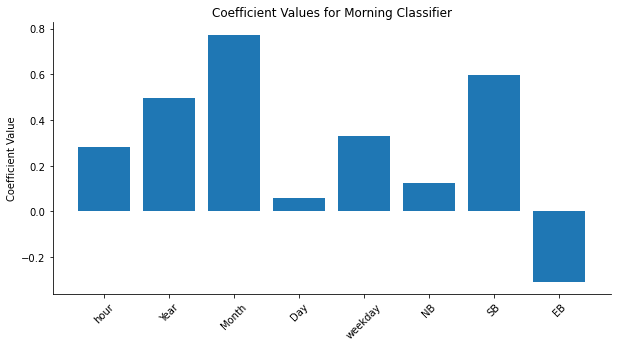

In [26]:
plt.figure(figsize=(10, 5))
plt.bar(X_morning_train.columns, logreg_morning.coef_[0])
plt.xticks(rotation=45)
plt.ylabel('Coefficient Value')
plt.title('Coefficient Values for Morning Classifier')
sns.despine()
plt.show()

With so many features, it can be difficult to interpret any meaningful trends.  It looks like `Month` and `SB` show the largest coefficients, while `EB` and `temperature` are actually negative.  The temperature coefficient is the most easily interpreted -- lower temperatures imply higher likelihood of collisions, which makes sense.  We can also infer though, that collisions near this intersection are more likely to occur later in the year, and when there is little eastbound traffic and heavy southbound traffic.  Note that these conclusions should be taken with caution though, as the model was trained on quite a small dataset.

As mentioned above, it will be particularly interesting to observe how the coefficients for `SB` and `NB` change from morning to evening, since we know that traffic counts along these directions change over the course of the day.  We can do this by first pulling out the appropriate coefficients from the model:

In [27]:
# get index of SB and NB features
SB_ix = list(X_morning_train.columns).index('SB')
NB_ix = list(X_morning_train.columns).index('NB')

# use indices to get coefficients of SB features
morning_SB_coef = logreg_morning.coef_[0][SB_ix]
evening_SB_coef = logreg_evening.coef_[0][SB_ix]

# use indices to get coefficients of NB features
morning_NB_coef = logreg_morning.coef_[0][NB_ix]
evening_NB_coef = logreg_evening.coef_[0][NB_ix]

With the coefficients in memory, we can then plot the variation:

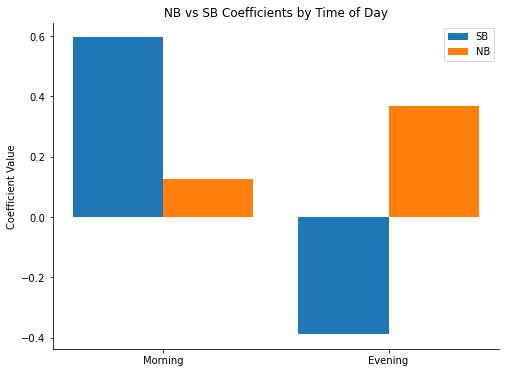

In [28]:
# set up plotting arrays / lists
x = np.arange(2, 4)
width = 0.4
SB_coefs = [morning_SB_coef, evening_SB_coef]
NB_coefs = [morning_NB_coef, evening_NB_coef]

# plot the coefficients
plt.figure(figsize=(8, 6))
plt.bar(x-width/2, SB_coefs, width, label='SB')
plt.bar(x+width/2, NB_coefs, width, label='NB')
plt.xticks(x, ['Morning', 'Evening'])
sns.despine()
plt.title('NB vs SB Coefficients by Time of Day')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

From looking at the change in coefficients from morning to evening, we can see some interesting results.  Given that the intersection is located *north* of the downtown core, it would be expected that southbound traffic is heavier in the morning, while northbound traffic is heavier in the evening (due to people commuting to and from work).  As a result, it is interesting to note that in the morning, the *southbound* coefficient is the greater of the two, implying that heavy southbound traffic is indicative of collisions.  Conversely, the reverse is true in the evening -- the *northbound* coefficient is greater.  

One potential explanation for this could be that if a collision occurs in a nearby area, vehicles will be more likely to take alternate routes, resulting in heavier traffic in the *expected* direction through *our* intersection.  It would be interesting to collect more data on a single intersection like this one, to see if this trend persists, and this could be a great next step for this project.

### Data for Tableau Visualizations

In addition to the figures generated in this notebook, we can take advantage of Tableau to produce map visualizations which provide easier-to-read geographical trends.  In particular, we can visualize the locations of collisions directly from the collisions table, and we can also visualize traffic fluctuations with a slightly modified traffic table.  Shown below is the code for generating such a table.

In [30]:
# clear the existing variables and read in the dataset once more
%reset -f

import pandas as pd
import numpy as np

joined = pd.read_csv('Data/joined_by_hour.csv')

In [31]:
# get the number of entries for each intersection
intersections = joined['Id_Intersection'].value_counts()

# pull out only those intersections which have a large number of entries
top_intersections = intersections[(intersections.values > 200)].index
top_intersections

Int64Index([ 1660,  6044,   303,   416,   399,   553,   546,  9873,   463,
               36,  1109,   983,    49,   250,  1192,   939,  7208,  1299,
             1049,  1735, 15739,  4852,   961,   274,   920,   972,  1249,
             1056,   866,   588,  8832,    47],
           dtype='int64')

In [32]:
# filter for top intersections
traffic_simple = joined.loc[joined['Id_Intersection'].isin(top_intersections), :]

# reset the index
traffic_simple = traffic_simple.reset_index().drop('index', axis=1)
traffic_simple.head()

,Id_Intersection,Date,hour,Longitude,Latitude,Year,Month,Day,weekday,NB,SB,EB,WB,collision_nearby
0,36,2014-01-27,0,-73.62897,45.463725,2014,1,27,0,0,0,0,0,0
1,36,2014-01-27,1,-73.62897,45.463725,2014,1,27,0,0,0,0,0,0
2,36,2014-01-27,2,-73.62897,45.463725,2014,1,27,0,0,0,0,0,0
3,36,2014-01-27,3,-73.62897,45.463725,2014,1,27,0,0,0,0,0,0
4,36,2014-01-27,4,-73.62897,45.463725,2014,1,27,0,0,0,0,0,0


In [34]:
# drop columns not useful for this plot (it's going to Tableau)
traffic_simple.drop(columns=['Year',
                            'Month',
                            'Day',
                            'weekday',
                            'collision_nearby'], inplace=True)

# aggregate the counts
traffic_simple['count'] = traffic_simple['NB'] + traffic_simple['SB'] + traffic_simple['EB'] + traffic_simple['WB']

# check results
traffic_simple.head()

,Id_Intersection,Date,hour,Longitude,Latitude,NB,SB,EB,WB,count
0,36,2014-01-27,0,-73.62897,45.463725,0,0,0,0,0
1,36,2014-01-27,1,-73.62897,45.463725,0,0,0,0,0
2,36,2014-01-27,2,-73.62897,45.463725,0,0,0,0,0
3,36,2014-01-27,3,-73.62897,45.463725,0,0,0,0,0
4,36,2014-01-27,4,-73.62897,45.463725,0,0,0,0,0


In [35]:
# save results
traffic_simple.to_csv('Data/traffic_simple_by_hour.csv', index=False)

### Explanation of Tableau Maps

#### Collisions

This map shows a density heatmap of all the collisions which were contained in the `collisions` dataset.  There are clearly some 'hot' zones where collisions are more likely to occur, mostly clustered around the downtown core.  We also see some areas where there have been no collisions.  In doing some quick research, we can see that these regions correspond to small lakes, areas devoted to greenspace, and even the airport.

#### Traffic by Direction

In this map, we see the overall average traffic count by intersection, with the colour scheme denoting whether it is typically southbound or northbound traffic passing through.  If there are generally more cars passing through heading southbound, the bubble is coloured orange, while if the average car is heading northbound, the bubble is coloured blue.  This allows us to visualize the general direction which cars are travelling by region.  We see a lot of orange bubbles in the area north of the downtown core, which is likely due to the high volume of people that go downtown every day.

#### Traffic by Direction by Hour

In this map, we see a similar visualization to the one shown in `Traffic by Direction`.  The colour scheme is the same, and we are again visualizing average traffic count by intersection.  The difference here is that we are now filtering by the hour of the day.  This makes it dynamic, in that the user can watch how both the traffic counts and direction vary over the course of the day, as the colour scheme updates accordingly as well.  It is particularly interesting to watch how many of the intersections located north of the downtown core display an orange colour through the morning and early afternoon, but switch to blue in the evening hours.  This is likely a reflection of commuters heading downtown in the morning (i.e. moving southbound), and heading home in the evening (i.e. moving northbound).

### Next Steps

As mentioned throughout the notebook, there are many potential avenues through which this work can be extended and improved.  These include:
- Exploration into different methods for joining the traffic and collisions tables.  Here, we set thresholds which defined whether a collision occurred 'near' an intersection, which may introduce bias into the dataset.  Our models may be learning where the clusters of ones are in our target variable, because we have this window in time that we set as a threshold.  One potential improvement for this problem would be to space our traffic entries out further in time, however this is made difficult with the current dataset, because the traffic entries are spread over 8 years with clusters of entries on specific days.


- Incorporating other features, such as traffic speed, precipitation and infrastructure.  Given the time constraints around this project, we decided to keep the data as simple as possible for the first iteration, using only traffic volume and some basic weather data to predict collisions.  However, it is very intuitive to think that other features may contribute to high collision rates as well, and so incorporating variables such as traffic speed could help the model make predictions.  Such data could also be taken from the Montreal Open Data Portal (similarly to what was done here), but detailed traffic speed data can also be scraped from the Google Maps platform through their API.


- As is the case for most machine learning models, more data would definitely help with this project.  While the initial dataset taken from the online portal had 1.5 million rows, many of these needed to be combined and aggregated, resulting in a final dataset with only ~70,000 rows.  In addition, while these all had associated time stamps, the entries were sparsely populated over 8 years, and so it made any time series analysis work quite difficult.  With a larger dataset that is more uniform in time, we could extend the analysis shown here to include forecasting and predictive models which look ahead in time.  While this may not be feasible with the data available through the Montreal portal, it could be possible to apply the work here to datasets available from other large cities.